In [2]:
# code draws heavily from
# https://github.com/openradar/AMS_radar_in_the_cloud/blob/master/notebooks/Putting_it_all_together.ipynb
#First out imports
#Lets import some stuff!
from datetime import datetime
import tempfile

from boto.exception import BotoServerError
from boto.s3.connection import S3Connection
import cartopy
from netCDF4 import num2date
import numpy as np
import pyart
import pytz
import pandas as pd
from os import chdir
from time import sleep
import matplotlib.pyplot as plt

# %matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [9]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))
    #print(bucket_list)

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    #print(datetimes)
    #print(datetime_t)
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [ ]:
os.getcwd()

In [ ]:
start_date, end_date = pd.to_datetime('20170130'), pd.to_datetime('20170301')
time_range = pd.date_range(start_date, end_date, freq='2H')
print(len(time_range))


stations = ['KHNX']
sleep_time = 45
radar_success = False
for st in stations:
    for t in time_range:
        error ="default error message"
        print(t, end = " ")
        try:
            print("fetching radar")
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BotoServerError:
            sleep(600)
            sleep_time += 10
            print('new sleep time between requests:', sleep_time)
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BaseException as error:
            print('An exception occurred: {}'.format(error))
            a = error
            radar_success = False
        
        filename = st + datetime.strftime(t,'d%Y%m%dt%H%M')
        
        if radar_success:
            pyart.io.write_cfradial(filename + '.cfradial',radar)
            radar_success = False
            print(filename, 'written')
            sleep(sleep_time)
        else:
            f = open(filename + '-err.txt', 'w')
            f.write(str(a))
            f.close()


In [ ]:
start_date, end_date = pd.to_datetime('20170203'), pd.to_datetime('20170302')
time_range = pd.date_range(start_date, end_date, freq='4H')
len(time_range)

In [ ]:
chdir('/Volumes/Backup/kojak_data')

stations = ['KBBX']
radar_success = False
sleep_time = 45
for st in stations:
    for t in time_range:
        print(t)
        try:
            radar = get_radar_from_aws(st, t)
            radar_success = True
            sleep_time = 45
            errcode = ''
        except BotoServerError:
            sleep(600)
        except BaseException as error:
            print('An exception occurred: {}'.format(error))
            radar_success = False
            errcode = 'err'
            sleep_time = 0
            
        filename = st + datetime.strftime(t,'d%Y%m%dt%H%M') + errcode + '.cfradial'
        pyart.io.write_cfradial(filename,radar)
        print(filename, 'written')
        sleep(sleep_time)

In [ ]:
start_date, end_date = pd.to_datetime('20170206'), pd.to_datetime('20170302')
time_range = pd.date_range(start_date, end_date, freq='4H')
print(len(time_range))

# Lets grab the latest radar volume from Seattle
chdir('/Volumes/Backup/kojak_data')

stations = 'KRGX KDAX KMUX KEYX KESX'.split()
stations = ['KRGX']
sleep_time = 40
radar_success = False
for st in stations:
    for t in time_range:
        print(t, end = " ")
        try:
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BotoServerError:
            sleep(600)
            sleep_time += 10
            print('new sleep time between requests:', sleep_time)
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BaseException as error:
            print('An exception occurred: {}'.format(error))
            radar_success = False
        
        filename = st + datetime.strftime(t,'d%Y%m%dt%H%M')
        
        if radar_success:
            pyart.io.write_cfradial(filename + '.cfradial',radar)
            radar_success = False
            print(filename, 'written')
            sleep(sleep_time)
        else:
            f = open(filename + '-err.txt', 'w')
            f.write(error)
            f.close()


In [ ]:
start_date, end_date = pd.to_datetime('20170219'), pd.to_datetime('20170302')
time_range = pd.date_range(start_date, end_date, freq='4H')
print(len(time_range))

# Lets grab the latest radar volume from Seattle
chdir('/Volumes/Backup/kojak_data')

stations = ['KDAX']

sleep_time = 40
radar_success = False
error ="default error message"
for st in stations:
    for t in time_range:
        print(t, end = " ")
        try:
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BotoServerError:
            sleep(600)
            sleep_time += 10
            print('new sleep time between requests:', sleep_time)
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BaseException as error:
            print('An exception occurred: {}'.format(error))
            a = error
            radar_success = False
        
        filename = st + datetime.strftime(t,'d%Y%m%dt%H%M')
        
        if radar_success:
            pyart.io.write_cfradial(filename + '.cfradial',radar)
            radar_success = False
            print(filename, 'written')
            sleep(sleep_time)
        else:
            error ='hello'
            f = open(filename + '-err.txt', 'w')
            f.write(str(a))
            f.close()


In [ ]:
start_date, end_date = pd.to_datetime('20170107'), pd.to_datetime('20170302')
time_range = pd.date_range(start_date, end_date, freq='4H')
print(len(time_range))

# Lets grab the latest radar volume from Seattle
chdir('/Volumes/Backup/kojak_data')

stations = ['KESX']  #KMUX KEYX'.split()

sleep_time = 50
radar_success = False
for st in stations:
    for t in time_range:
        error ="default error message"
        print(t, end = " ")
        try:
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BotoServerError:
            sleep(600)
            sleep_time += 10
            print('new sleep time between requests:', sleep_time)
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BaseException as error:
            print('An exception occurred: {}'.format(error))
            a = error
            radar_success = False
        
        filename = st + datetime.strftime(t,'d%Y%m%dt%H%M')
        
        if radar_success:
            pyart.io.write_cfradial(filename + '.cfradial',radar)
            radar_success = False
            print(filename, 'written')
            sleep(sleep_time)
        else:
            f = open(filename + '-err.txt', 'w')
            f.write(str(a))
            f.close()


In [ ]:
start_date, end_date = pd.to_datetime('20170223'), pd.to_datetime('20170302')
time_range = pd.date_range(start_date, end_date, freq='4H')
print(len(time_range))

# Lets grab the latest radar volume from Seattle
chdir('/Volumes/Backup/kojak_data')

stations = 'KMUX KEYX'.split()
stations = ['KMUX']
sleep_time = 45
radar_success = False
for st in stations:
    for t in time_range:
        error ="default error message"
        print(t, end = " ")
        try:
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BotoServerError:
            sleep(600)
            sleep_time += 5
            print('new sleep time between requests:', sleep_time)
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BaseException as error:
            print('An exception occurred: {}'.format(error))
            a = error
            radar_success = False
        
        filename = st + datetime.strftime(t,'d%Y%m%dt%H%M')
        
        if radar_success:
            pyart.io.write_cfradial(filename + '.cfradial',radar)
            radar_success = False
            print(filename, 'written')
            sleep(sleep_time)
        else:
            f = open(filename + '-err.txt', 'w')
            f.write(str(a))
            f.close()


In [ ]:
start_date, end_date = pd.to_datetime('20170101'), pd.to_datetime('20170302')
time_range = pd.date_range(start_date, end_date, freq='4H')
print(len(time_range))

# Lets grab the latest radar volume from Seattle
chdir('/Volumes/Backup/kojak_data')

stations = ['KEYX']
sleep_time = 45
radar_success = False
for st in stations:
    for t in time_range:
        error ="default error message"
        print(t, end = " ")
        try:
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BotoServerError:
            sleep(600)
            sleep_time += 5
            print('new sleep time between requests:', sleep_time)
            radar = get_radar_from_aws(st, t)
            radar_success = True
        except BaseException as error:
            print('An exception occurred: {}'.format(error))
            a = error
            radar_success = False
        
        filename = st + datetime.strftime(t,'d%Y%m%dt%H%M')
        
        if radar_success:
            pyart.io.write_cfradial(filename + '.cfradial',radar)
            radar_success = False
            print(filename, 'written')
            sleep(sleep_time)
        else:
            f = open(filename + '-err.txt', 'w')
            f.write(str(a))
            f.close()


In [16]:
# Lets get some geographical context
lats = radar.gate_latitude
lons = radar.gate_longitude

zoom = 1.5
min_lon = lons['data'].min() + zoom
min_lat = lats['data'].min() + zoom
max_lat = lats['data'].max() - zoom
max_lon = lons['data'].max() - zoom-1

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)

sweep = 0
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

min_lat: 33.6847033946  min_lon: -123.259292952  max_lat: 38.9434540933  max_lon: -117.004993349
Tuesday February 07 at 03:59 AM PST


In [56]:
!cd new_data
!ls

KHNXd20170115t0000-err.txt process_model_data.ipynb
KHNXd20170115t0200-err.txt process_radar_data.ipynb
composite_df.pkl           process_sensor_data.ipynb
data_temp                  rdr_coords.pkl
get_radar_data.ipynb       ref
get_snow_data.ipynb        refl_new.pkl
googleapikey.txt           results_exploration.ipynb
kojak-pres.key             rf_results.pkl
model_ens_snow_data.ipynb  snow_scraped_df.pkl
model_nn_snow_data.ipynb   sr_df.pkl
new_data


In [11]:
chdir("new_data")
radar = pyart.io.read_cfradial('KHNXd20170207t1200.cfradial')

In [13]:
chdir("..")
9!ls

KHNXd20170115t0000-err.txt model.png
KHNXd20170115t0200-err.txt model_ens_snow_data.ipynb
composite_df.pkl           model_nn_snow_data.ipynb
data_temp                  new_data
download (1).png           process_model_data.ipynb
download (2).png           process_radar_data.ipynb
download (3).png           process_sensor_data.ipynb
download (4).png           rdr_coords.pkl
download.png               ref
fi.png                     refl_new.pkl
foo.pdf                    results_exploration.ipynb
get_radar_data.ipynb       rf_results.pkl
get_snow_data.ipynb        rnn_results.pkl
googleapikey.txt           snow_in_chart.png
khnx_radar.png             snow_scraped_df.pkl
kojak-pres.key             sr_df.pkl
line.pdf                   xgb_results.pkl


In [3]:
sensor_data = pd.read_pickle('sr_df.pkl')
khnx_sensors = sensor_data[sensor_data['r_closest'] == 'khnx'].reset_index(drop=True)
sensor_coords = khnx_sensors[['st_code','st_lon','st_lat']].drop_duplicates(subset='st_code')

In [10]:
for i,s in sensor_coords.iterrows():
    print(s['st_lat'],',', s['st_lon'], end='')

37.897 , -119.25737.873 , -119.3537.838 , -119.44837.859 , -119.65237.388 , -118.90337.724 , -119.14337.3 , -119.137.555 , -119.23837.629 , -119.08537.165 , -119.237.41 , -119.4937.228 , -119.22137.403 , -119.5237.1 , -118.55736.927 , -118.57437.184 , -118.93837.03 , -118.91836.715 , -118.84336.415 , -118.57936.118 , -118.5436.562 , -118.76536.497 , -118.44736.348 , -118.57236.367 , -118.28836.198 , -118.27236.126 , -118.29337.78 , -119.1737.162 , -118.56337.128 , -118.47837.176 , -118.56337.61 , -119.033

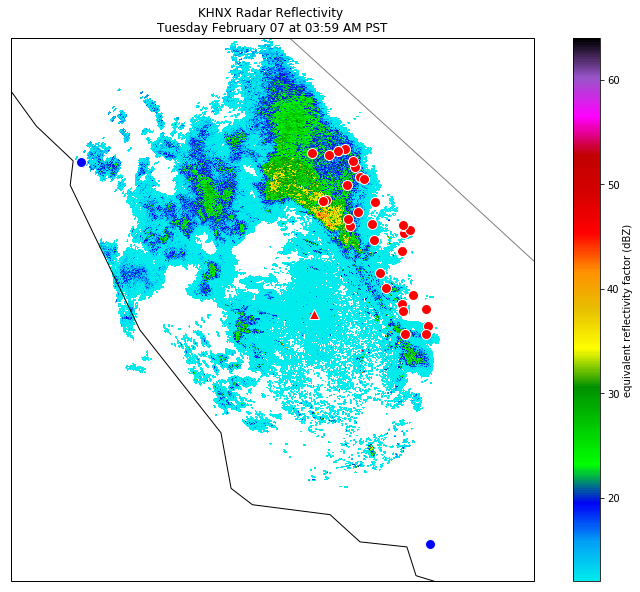

In [53]:
# radar coverage map
# https://gis.ncdc.noaa.gov/maps/ncei/radar
# Level II is the radar data after a small amount of initial processing. 
# Level II data only consists of Base Reflectivity (0.5 dBz increments), 
# Radial Velocity (1kt increments), and Spectrum Width. The radial 
# resolution of the velocity product is 250m. In terms of vertical 
# resolution, there are typical 9-14 vertical tilts availab.e



fig = plt.figure(figsize = [14,10])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

title = 'KHNX Radar Reflectivity \n' + fancy_date_string

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=12, vmax=64)

# Mark the radar
display.plot_point(lon_0, lat_0, symbol='^r', MarkerEdgeColor='w', MarkerSize=10)
display.plot_point(-122.4194, 37.7749, symbol='ob', MarkerEdgeColor='w', MarkerSize=10)
display.plot_point(-118.2437, 34.0522, symbol='ob', MarkerEdgeColor='w', MarkerSize=10)

# plot snow sensors
for s in sensor_coords.iterrows():
    display.plot_point(s[1]['st_lon'], s[1]['st_lat'], symbol='or', MarkerEdgeColor='w', MarkerSize=10)

# Plot some lat and lon lines
#gl = display.ax.gridlines(draw_labels=True,
#                         linewidth=2, color='gray', alpha=0, linestyle='--')
#gl.xlabels_top = False
#gl.ylabels_right = False
plt.savefig('radar.png')
plt.show()

In [ ]:
plt.savefig

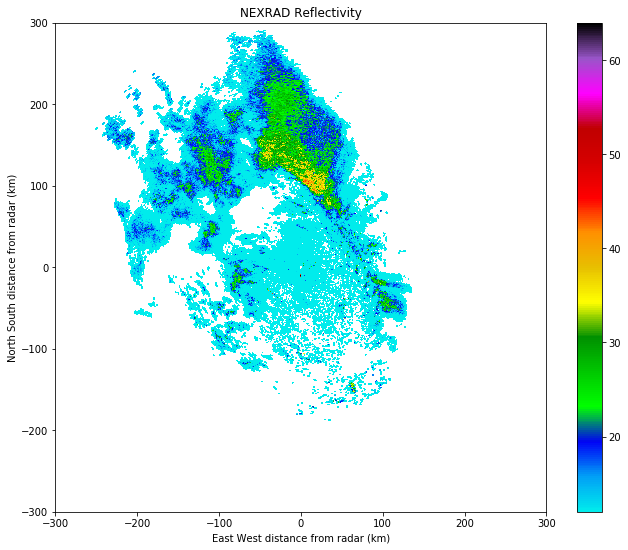

In [55]:

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(11, 9))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, title='NEXRAD Reflectivity',
             vmin=12, vmax=64, colorbar_label='', ax=ax)
display.plot_range_ring(radar.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-300, 300), ylim=(-300, 300), ax=ax)

plt.savefig('radar2.png')
plt.show()